In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Aim 1 - look at allele frequencies in 756 cells from RN that have at least 100 reads for each of 4 amplicons
#Aim 2 - practise dataframe manipulation so I'm not constantly making sub-frames and tying myself in knots

In [148]:
#Import all the data again
#Import the data and flip into a multi index 
df = pd.read_csv('../Data/allele_counts.tsv', header = [0,1,2], index_col = 0, sep='\t')
df = df.stack([0,1,2])
df = df.reorder_levels([1,0,2,3])
df = df.to_frame()  #puts everything back in a dataframe
df.columns = ['Reads']
df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
df['Well'] = df.index.get_level_values(1)
df['Amplicon'] = df.index.get_level_values(2)
df['Genotype'] = df.index.get_level_values(3)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two'])
print(df.shape[0]) #shape of the df in the height dimension

84480


In [35]:
#Need to be able to assign patient and cell type from the plate ID

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

#Make a dictionary to associate plates with patients and plate with cell type
plate_pt_dict = dict(zip(key.Plate, key.Patient))
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

In [149]:
#Set up some lists for iteration
patients = ['RN', 'EL', 'GR']
plates = df['Plate'].drop_duplicates().to_list()
amplicons = df['Amplicon'].drop_duplicates().to_list()
genos = df['Genotype'].drop_duplicates().to_list()
wells = df['Well'].drop_duplicates().to_list()

In [206]:
#Reads per well per plate
read_plate = df.groupby(['Plate', 'Well']).sum()
read_plate = read_plate.reset_index()
read_plate['Number'] = read_plate['Well'].str.replace('([A-Z]+)', '')
read_plate['Letter'] = read_plate['Well'].str.extract('([A-Z]+)')
read_plate = read_plate.drop(columns = ['Well'])

In [152]:
#plot reads per plate 
fig, axs = plt.subplots(9,3, figsize = (16, 18))
fig.subplots_adjust(hspace = 1, wspace=.2)
axs = axs.ravel()

count = -1

for plate in plates:
    
    j = plate_pt_dict.get(plate) #use the dict to make a variable that contains the patient name for the current plate
    m = plate_cell_dict.get(plate) #use the dict to make a variable that contains the cell ype for the current plate    
        
    count = count + 1
    a = read_plate.loc[read_plate['Plate'].isin([plate])]
    a = a.pivot(index = 'Letter', columns = 'Number', values = 'Reads')
    #Re-order data here ot get proper plate layout
    a = np.minimum(a, 100)    
                       
    axs[count] = sns.heatmap(a, cmap = 'YlGnBu_r', ax = axs[count])#Plot the data on the next ax
    axs[count].set_title(str(plate+' '+j+' '+m)) #set title to contain plate and cell type

fig.suptitle('Total reads per well/per plate (max100)', fontsize=16)
fig.savefig('../Results/Well_counts/well_counts_total_max100.png',dpi=600)  

plt.close() #Plot just goes to file and isn't displayed

In [185]:
#Reads per amplicon per well per plate
#Makes sense to split into patients at this point
amps_plate = df.groupby(['Plate', 'Well', 'Amplicon', 'Patient']).sum() #group by plate, well, amplicon, patient
amps_plate['Patient'] = amps_plate.index.get_level_values(3) #Put patient ID back into a column

RN_amps_plate = amps_plate.loc[amps_plate['Patient'].isin(['RN'])]
RN_amps_plate = RN_amps_plate.drop(columns = 'Patient') #Remove patient column
RN_amps_plate = RN_amps_plate.unstack(level = 2) #unstack to split amplicons into columns

EL_amps_plate = amps_plate.loc[amps_plate['Patient'].isin(['EL'])]
EL_amps_plate = EL_amps_plate.drop(columns = 'Patient')  #Remove patient column
EL_amps_plate = EL_amps_plate.unstack(level = 2) #unstack to split amplicons into columns

GR_amps_plate = amps_plate.loc[amps_plate['Patient'].isin(['GR'])]
GR_amps_plate = GR_amps_plate.drop(columns = 'Patient')  #Remove patient column
GR_amps_plate = GR_amps_plate.unstack(level = 2) #unstack to split amplicons into columns

#Check there's data for 9 x 384 = 3456 wells
print(RN_amps_plate.shape[0])
print(EL_amps_plate.shape[0])
print(GR_amps_plate.shape[0])

3456
3456
3456


In [205]:
#Just look at RN now

#Looking at all amplicons

cells100 = RN_amps_plate.loc[(RN_amps_plate >= 100).all(axis=1)]
cells50 = RN_amps_plate.loc[(RN_amps_plate >= 50).all(axis=1)]
cells10 = RN_amps_plate.loc[(RN_amps_plate >= 10).all(axis=1)]

print('Looking at all 6 amplicons;')
print('Cells with at least 10 reads per amplicon = ' + str(cells10.shape[0]))
print('Cells with at least 50 reads per amplicon = ' + str(cells50.shape[0]))
print('Cells with at least 100 reads per amplicon = ' + str(cells100.shape[0]))
print('')

#Now excluding TET2b amplicons
RN_some_amps_plate = RN_amps_plate.iloc[: , 0:4]


somecells100 = RN_some_amps_plate.loc[(RN_some_amps_plate >= 100).all(axis=1)]
somecells50 = RN_some_amps_plate.loc[(RN_some_amps_plate >= 50).all(axis=1)]
somecells10 = RN_some_amps_plate.loc[(RN_some_amps_plate >= 10).all(axis=1)]

print('Looking at 4 amplicons (not TET2b);')
print('Cells with at least 10 reads per amplicon = ' + str(somecells10.shape[0]))
print('Cells with at least 50 reads per amplicon  = ' + str(somecells50.shape[0]))
print('Cells with at least 100 reads per amplicon = ' + str(somecells100.shape[0]))


Looking at all 6 amplicons;
Cells with at least 10 reads per amplicon = 0
Cells with at least 50 reads per amplicon = 0
Cells with at least 100 reads per amplicon = 0

Looking at 4 amplicons (not TET2b);
Cells with at least 10 reads per amplicon = 2149
Cells with at least 50 reads per amplicon  = 1178
Cells with at least 100 reads per amplicon = 756


Text(0.5, 0.98, 'RN - cells with >x reads for all amplicons')

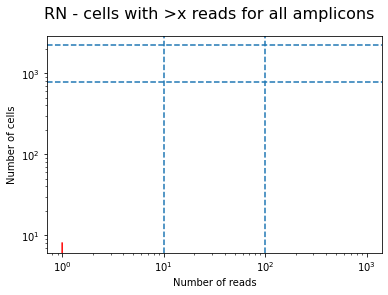

In [207]:
#Plotting the read distributions
#All amplicons
x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
y = [RN_amps_plate.loc[(RN_amps_plate >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
fig, ax = plt.subplots()
ax.plot(x, y, color = 'red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(10, ls = '--')
ax.axvline(100, ls = '--')
ax.axhline(2200, ls = '--')
ax.axhline(780, ls = '--')
ax.set_xlabel('Number of reads')
ax.set_ylabel('Number of cells')

fig.suptitle('RN - cells with >x reads for all amplicons', fontsize=16)        
#fig.savefig('../Results/Amp_counts/RN_amp_counts_per_cell_all_amplicons.png',dpi=600) 

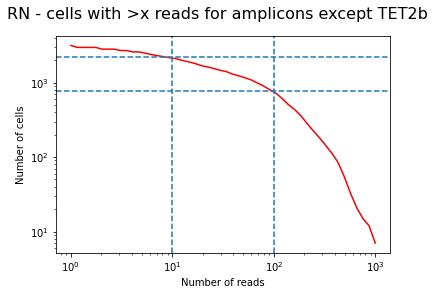

In [209]:
#Plotting the read distributions
#Amplicons except TET2b
x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
y = [RN_some_amps_plate.loc[(RN_some_amps_plate >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
fig, ax = plt.subplots()
ax.plot(x, y, color = 'red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(10, ls = '--')
ax.axvline(100, ls = '--')
ax.axhline(2200, ls = '--')
ax.axhline(780, ls = '--')
ax.set_xlabel('Number of reads')
ax.set_ylabel('Number of cells')

fig.suptitle('RN - cells with >x reads for amplicons except TET2b', fontsize=16)        
fig.savefig('../Results/Amp_counts/RN_amp_counts_per_cell_amplicons_except TET2b.png',dpi=600) 

In [262]:
#Iterable lists of amplicons from column headers
#Bad solution, ended up with labels in the wrong order
EL_col = [] #Make empty lists
GR_col = []
RN_col = []

col_headers = list(EL_amps_plate.columns.levels[1]) #Grabs the column headers from multi index
for x in col_headers:
    if 'EL' in x:
        EL_col.append(x)

col_headers = list(GR_amps_plate.columns.levels[1]) #Grabs the column headers from multi index
for x in col_headers:
    if 'GR' in x:
        GR_col.append(x)  
        
col_headers = list(RN_amps_plate.columns.levels[1]) #Grabs the column headers from multi index
for x in col_headers:
    if 'RN' in x:
        RN_col.append(x) 

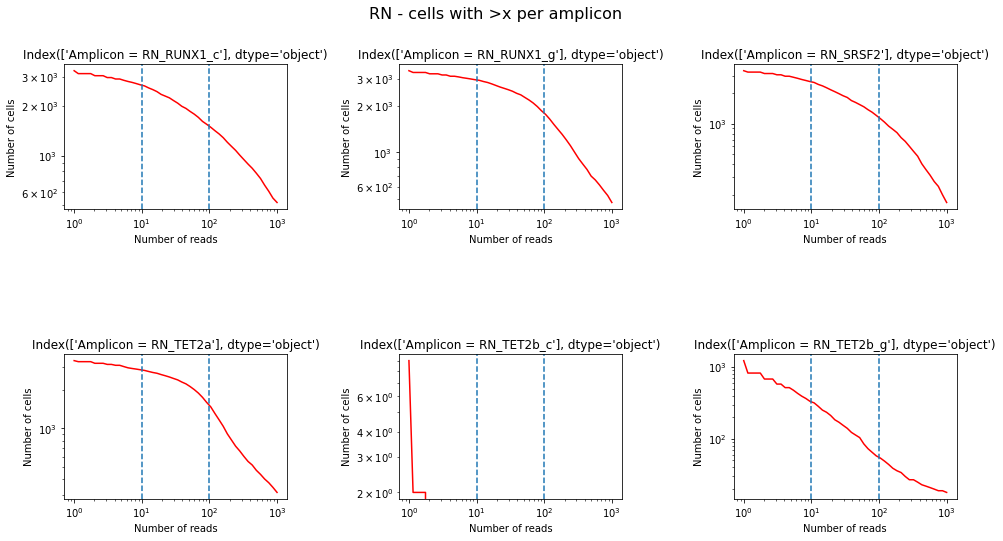

In [271]:
#Plot each individual amplicon
fig, ax = plt.subplots(2,3, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()
count = -1

for z in range(6):
    count = count + 1
    data = RN_amps_plate.iloc[: , z].to_frame()
    x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
    y = [data.loc[(data >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
    
    a = data.columns.levels[1]
    
    ax[count].plot(x, y, color = 'red')
    ax[count].set_yscale('log')
    ax[count].set_xscale('log')
    ax[count].axvline(10, ls = '--')
    ax[count].axvline(100, ls = '--')
    #ax[count].axhline(2200, ls = '--')
    #ax[count].axhline(780, ls = '--')
    ax[count].set_xlabel('Number of reads')
    ax[count].set_ylabel('Number of cells')
    ax[count].set_title('Amplicon = ' + a)
    
fig.suptitle('RN - cells with >x per amplicon', fontsize=16)        
fig.savefig('../Results/Amp_counts/RN_amp_counts_per_cell_per_amplicons.png',dpi=600) 

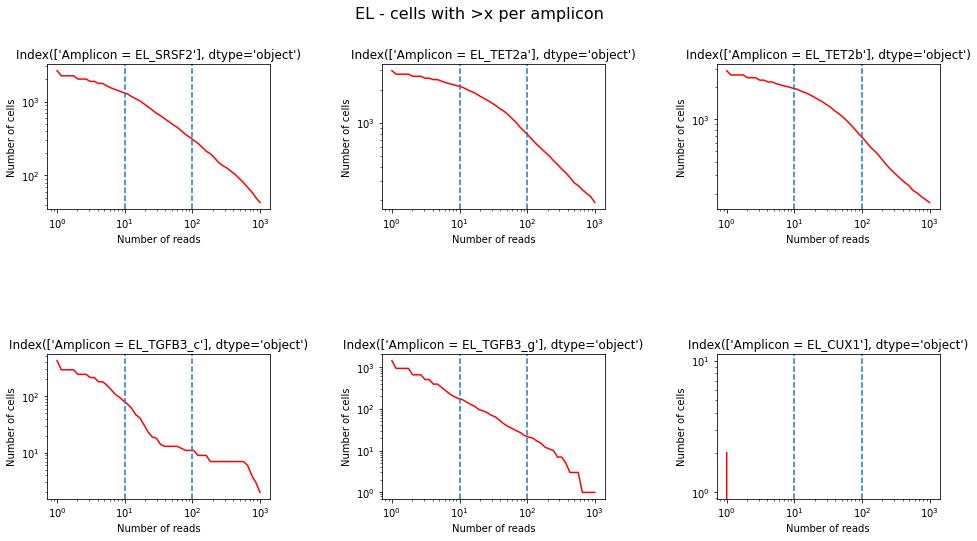

In [272]:
#Plot each individual amplicon for EL
fig, ax = plt.subplots(2,3, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()
count = -1

for z in range(6):
    count = count + 1
    data = EL_amps_plate.iloc[: , z].to_frame()
    x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
    y = [data.loc[(data >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
    
    a = data.columns.levels[1]
    
    ax[count].plot(x, y, color = 'red')
    ax[count].set_yscale('log')
    ax[count].set_xscale('log')
    ax[count].axvline(10, ls = '--')
    ax[count].axvline(100, ls = '--')
    #ax[count].axhline(2200, ls = '--')
    #ax[count].axhline(780, ls = '--')
    ax[count].set_xlabel('Number of reads')
    ax[count].set_ylabel('Number of cells')
    ax[count].set_title('Amplicon = ' + a)
    
fig.suptitle('EL - cells with >x per amplicon', fontsize=16)        
fig.savefig('../Results/Amp_counts/EL_amp_counts_per_cell_per_amplicons.png',dpi=600) 

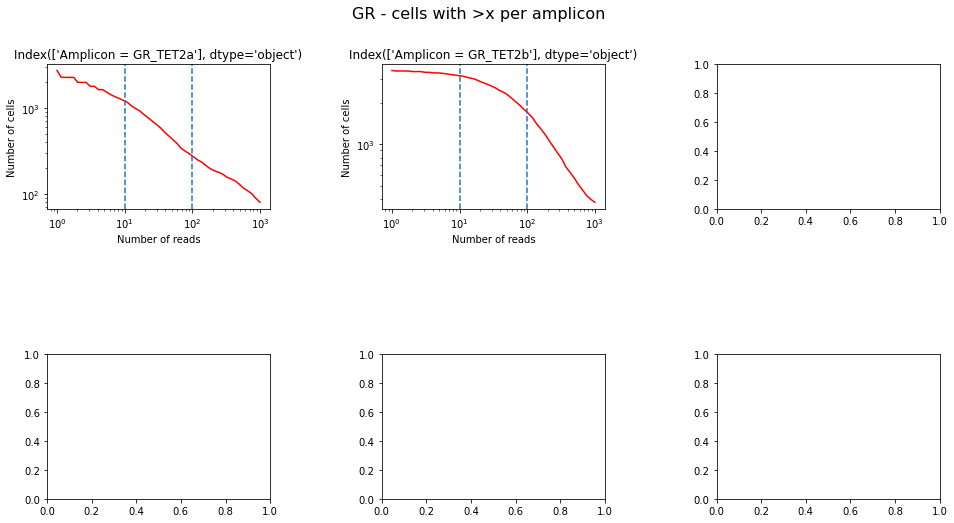

In [273]:
#Plot each individual amplicon for GR
fig, ax = plt.subplots(2,3, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()
count = -1

for z in range(2):
    count = count + 1
    data = GR_amps_plate.iloc[: , z].to_frame()
    x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
    y = [data.loc[(data >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
    
    a = data.columns.levels[1]
    
    ax[count].plot(x, y, color = 'red')
    ax[count].set_yscale('log')
    ax[count].set_xscale('log')
    ax[count].axvline(10, ls = '--')
    ax[count].axvline(100, ls = '--')
    #ax[count].axhline(2200, ls = '--')
    #ax[count].axhline(780, ls = '--')
    ax[count].set_xlabel('Number of reads')
    ax[count].set_ylabel('Number of cells')
    ax[count].set_title('Amplicon = ' + a)
    
fig.suptitle('GR - cells with >x per amplicon', fontsize=16)        
fig.savefig('../Results/Amp_counts/GR_amp_counts_per_cell_per_amplicons.png',dpi=600) 

In [266]:
EL_amps_plate

Reads                                                
Amplicon            EL_SRSF2 EL_TET2a EL_TET2b EL_TGFB3_c EL_TGFB3_g EL_CUX1
Plate  Well Patient                                                         
AS-202 A1   EL           0.0      1.0      1.0        0.0        0.0     NaN
       A10  EL           0.0      2.0      0.0        0.0        0.0     NaN
       A11  EL           0.0     14.0      8.0        0.0        0.0     NaN
       A12  EL           6.0     33.0     47.0        0.0        3.0     NaN
       A13  EL          13.0     43.0     41.0        0.0        2.0     NaN
...                      ...      ...      ...        ...        ...     ...
AS-210 P5   EL           0.0     17.0     21.0        1.0       20.0     0.0
       P6   EL          13.0      0.0      2.0        0.0        0.0     0.0
       P7   EL           0.0      1.0      3.0        0.0        0.0     0.0
       P8   EL          21.0      3.0      4.0        0.0        0.0     0.0
       P9   EL          16.0      1.0      3.0        0.0        2.0     0.0

[3456 rows x 6 columns]